In [105]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [106]:
# Set in stone
data_path = '../axej/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [107]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# ExpOrientation (expOri): 1,2,3,4,5 -> 159, 123, 87, 51, 15
att = []
coh = []
exp = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

            try:
                # print(data["expOri"])
                exp.append([experiment_orientations[data["expOri"] - 1]]*n_trials)
            except:
                # print("No expOri")
                exp.append([np.nan]*n_trials)
                

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)
exp = np.array(exp, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape, att.shape, coh.shape, exp.shape

100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


((13, 4, 6, 120, 500),
 (13, 4, 6, 120, 500),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120))

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [108]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles, final_resp_idx = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap, do_noise_thresh=False)

In [109]:
# Calculate the velocity and acceleration of the joystick

# Velocity
jx_vel = np.diff(shifted_jx, axis=-1)
jy_vel = np.diff(shifted_jy, axis=-1)

# Acceleration
jx_acc = np.diff(jx_vel, axis=-1)
jy_acc = np.diff(jy_vel, axis=-1)

jx_vel.shape, jy_vel.shape, jx_acc.shape, jy_acc.shape

((13, 4, 6, 120, 999),
 (13, 4, 6, 120, 999),
 (13, 4, 6, 120, 998),
 (13, 4, 6, 120, 998))

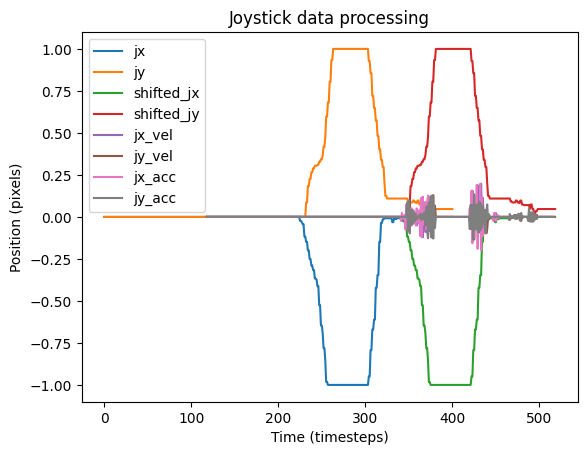

In [110]:
# Plot the velocity and acceleration of the joystick for visual inspection
for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                plt.plot(jx[subj, sess, run, trial], label="jx")
                plt.plot(jy[subj, sess, run, trial], label="jy")
                plt.plot(shifted_jx[subj, sess, run, trial], label="shifted_jx")
                plt.plot(shifted_jy[subj, sess, run, trial], label="shifted_jy")
                plt.plot(jx_vel[subj, sess, run, trial], label="jx_vel")
                plt.plot(jy_vel[subj, sess, run, trial], label="jy_vel")
                plt.plot(jx_acc[subj, sess, run, trial], label="jx_acc")
                plt.plot(jy_acc[subj, sess, run, trial], label="jy_acc")
                plt.legend()
                # x and y axis labels
                plt.xlabel("Time (timesteps)")
                plt.ylabel("Position (pixels)")
                plt.title("Joystick data processing")
                plt.show()
                break
            break
        break
    break

In [111]:
# Final response velocity and acceleration
final_resp_loc_jx = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
final_resp_loc_jy = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
final_resp_vel_jx = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
final_resp_vel_jy = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
final_resp_acc_jx = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
final_resp_acc_jy = np.zeros((n_subjects, n_sessions, n_runs, n_trials))

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                final_resp_loc_jx[subj, sess, run, trial] = shifted_jx[subj, sess, run, trial, final_resp_idx[subj, sess, run, trial]]
                final_resp_loc_jy[subj, sess, run, trial] = shifted_jy[subj, sess, run, trial, final_resp_idx[subj, sess, run, trial]]
                final_resp_vel_jx[subj, sess, run, trial] = shifted_jx[subj, sess, run, trial, final_resp_idx[subj, sess, run, trial]]
                final_resp_vel_jy[subj, sess, run, trial] = shifted_jy[subj, sess, run, trial, final_resp_idx[subj, sess, run, trial]]
                final_resp_acc_jx[subj, sess, run, trial] = shifted_jy[subj, sess, run, trial, final_resp_idx[subj, sess, run, trial]]
                final_resp_acc_jy[subj, sess, run, trial] = shifted_jy[subj, sess, run, trial, final_resp_idx[subj, sess, run, trial]]

final_resp_vel_jx.shape, final_resp_vel_jy.shape, final_resp_acc_jx.shape, final_resp_acc_jy.shape, final_resp_loc_jx.shape, final_resp_loc_jy.shape

((13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120))

In [112]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "removed trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% removed trials")

0 removed trials
0.0 % removed trials


## Circular stat defs

In [113]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [114]:
calib_median = np.load("../analysis/cache/circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [115]:
calib_std = np.load("../analysis/cache/circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Design Matrix

Things that are considered as u_t

- Calibrated stimulus (median)
- Coherece
- Attention 
- Expectation

compared:

- bias

In [116]:
stimulus = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
exp_cali = np.zeros((n_subjects, n_sessions, n_runs, n_trials))

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                target_key = median_key[stimdir[subj, sess, run, trial]]
                stimulus[subj, sess, run, trial] = calib_median[subj, target_key]

                exp_t = exp[subj, sess, run, trial]
                if np.isnan(exp_t):
                    exp_cali[subj, sess, run, trial] = np.nan
                else:
                    exp_key = median_key[exp_t]
                    exp_cali[subj, sess, run, trial] = calib_median[subj, exp_key]

#### Attention + Coherence + Expectation:

In [117]:
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# coh = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# att = []

# ExpOrientation (expOri): 1,2,3,4,5 -> 159, 123, 87, 51, 15 -> calib_median
# exp_cali = []

In [118]:
coh.shape, att.shape, exp_cali.shape

((13, 4, 6, 120), (13, 4, 6, 120), (13, 4, 6, 120))

In [119]:
coh[coh == 1] = 0
coh[coh == 2] = 1

att[att == 1] = 1
att[att == 2] = 0

## Cleanup and standardization

In [120]:
final_resp_vel_jx.shape, final_resp_vel_jy.shape, final_resp_acc_jx.shape, final_resp_acc_jy.shape, final_resp_loc_jx.shape, final_resp_loc_jy.shape

((13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120))

In [121]:
stimulus.shape

(13, 4, 6, 120)

In [122]:
# make stimulus from angles 0to360 to x and y

stimulus_x = np.cos(np.radians(stimulus))
stimulus_y = np.sin(np.radians(stimulus))

-0.8278397329336239
0.560964683894081
145.8774616545835


(-1.0, 1.0)

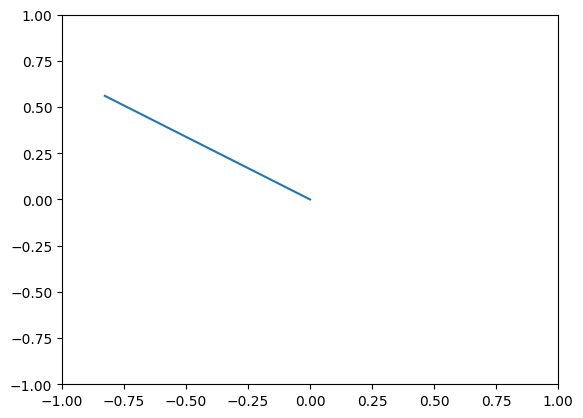

In [123]:
# Sanity checking co-ordinate extraction

# plot these for checking
print(stimulus_x[0,0,0,0])
print(stimulus_y[0,0,0,0])
print(stimulus[0,0,0,0])

# plot a line to sitm x and y from 0,0
plt.plot([0, stimulus_x[0,0,0,0]], [0, stimulus_y[0,0,0,0]])
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [124]:
# total variables
# final_resp_loc_jx, final_resp_loc_jy,
# final_resp_vel_jx, final_resp_vel_jy,
# final_resp_acc_jx, final_resp_acc_jy,

In [125]:
final_resp_vel_jx.shape, final_resp_vel_jy.shape, final_resp_acc_jx.shape, final_resp_acc_jy.shape, final_resp_loc_jx.shape, final_resp_loc_jy.shape

((13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120))

In [126]:
coh.shape, att.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [127]:
stimulus_x.shape, stimulus_y.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [128]:
# All the data is now ready for the model
total_data = np.stack([final_resp_loc_jx, final_resp_loc_jy, final_resp_vel_jx, final_resp_vel_jy, final_resp_acc_jx, final_resp_acc_jy, stimulus_x, stimulus_y, coh, att], axis=0)

In [129]:
total_data.shape

(10, 13, 4, 6, 120)

In [132]:
# count nan
# loop through all and print the nan count
for i in range(total_data.shape[0]):
    print(np.isnan(total_data[i]).sum())
    # show the index of the nan
    print(np.argwhere(np.isnan(total_data[i])))

0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]
0
[]


In [133]:
# save the data
# np.save("../analysis/cache/total_data.npy", total_data)

In [39]:
# Remove trials with no expectation manipulation

exp_obs = final_resp_angles[:, :, :5, :].reshape(-1, 120)

exp_stim = stimulus[:, :, :5, :]
exp_coh = coh[:, :, :5, :]
exp_att = att[:, :, :5, :]
exp_exp = exp_cali[:, :, :5, :]

exp_design_matrix = np.stack([exp_stim, exp_coh, exp_att, exp_exp], axis=-1).reshape(-1, 120, 4)

exp_stim.shape, exp_coh.shape, exp_att.shape, exp_exp.shape, exp_obs.shape, exp_design_matrix.shape

((13, 4, 5, 120),
 (13, 4, 5, 120),
 (13, 4, 5, 120),
 (13, 4, 5, 120),
 (260, 120),
 (260, 120, 4))

In [19]:
valid_obs = np.expand_dims(np.array(exp_obs), -1)
valid_design = np.array(exp_design_matrix)

valid_obs.shape, valid_design.shape

((260, 120, 1), (260, 120, 4))

In [20]:
# np.save("../analysis/cache/exp_obs.npy", valid_obs)
# np.save("../analysis/cache/exp_design.npy", valid_design)